In [140]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import jax.numpy as jnp
from jax import grad
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

In [141]:
def rho(x,y,z,e,p,q,rho0,s,a,b):
    """
    Calculate density value based on input coordinates and parameters.

    Parameters:
    x (float or array-like): x-coordinate(s) of the point(s).
    y (float or array-like): y-coordinate(s) of the point(s).
    z (float or array-like): z-coordinate(s) of the point(s).
    e (float): Parameter describing the disky/boxiness of the triaxial body.
    p (float): Axis ratio b/a.
    q (float): Axis ratio c/a.
    rho0 (float): Normalization parameter for density.
    s (float): Scale radius.
    a (float): Power-law exponent.
    b (float): Power-law exponent.

    Returns:
    float or array-like: Density value(s) at the given coordinates.

    Formula:
    The function calculates density value(s) based on the input coordinates (x, y, z) and parameters (e, p, q, rho0, s, a, b)
    using the following formula:

        r = ((|x|^(2 - e) + (|y| / p)^(2 - e) + (|z| / q)^(2 - e)))^(1/(2-e))
        rho = rho0 / ((r / s)^a * (1 + (r / s))^(b - a))

    where:
        |x|, |y|, |z|: Absolute values of the coordinates.
        e: Exponent parameter.
        p, q: Scaling parameters for x and y coordinates.
        rho0: Normalization parameter for density.
        s: Scaling parameter for distance.
        a, b: Shape parameters.
        r: Distance metric calculated based on the input coordinates.
        rho: Density value calculated based on the input parameters and coordinates.
    """
    r = ((jnp.abs(x)**(2 - e) + (jnp.abs(y) / p)**(2 - e) + (jnp.abs(z) / q)**(2 - e)))**(1/(2-e))
    den = rho0 / ((r/s)**a*(1+(r/s))**(b-a))
    #den = np.round(den, decimals=6)
    return den

In [142]:
def projection(density_mat):
    """
    Returns the 2D projection of a 3D density matrix along the z-axis.

    Parameters:
    - density_mat (numpy.ndarray): The 3D density matrix representing the density distribution.
                                   The shape of the matrix should be (M, N, K), where M, N, and K
                                   are the dimensions along the x, y, and z axes respectively.

    Returns:
    float or array-like: Projected Density value(s) along the z-axis.

    This function calculates the projection of the given density matrix along the z-axis,
    summing up the values along the z-axis to produce a 2D array. 
    """
    projection_z_axis = jnp.sum(density_mat, axis = 2)
    return projection_z_axis

In [143]:
def plot_img(proj_density_mat, title = ''):
    """
    Plot a 2D image with a logarithmically scaled colour bar.

    Parameters:
    - proj_density_mat (numpy.ndarray): The 2D density matrix representing the density distribution projected along the z-axis.
                                   

    Returns:
    None

    This function uses Plotly matplotlib
    to create and display an image plot of the projected density with a logarithmically scaled colour bar..
    """
    plt.imshow(proj_density_mat, origin= 'lower')
    plt.colorbar(label='Color Scale')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.show()

In [144]:
def plot_img_logscale(proj_density_mat):
    """
    Plot a 2D image with a logarithmically scaled colour bar.

    Parameters:
    - proj_density_mat (numpy.ndarray): The 2D density matrix representing the density distribution projected along the z-axis.
                                   

    Returns:
    None

    This function uses Plotly matplotlib
    to create and display an image plot of the projected density with a logarithmically scaled colour bar..
    """
    plt.imshow(proj_density_mat, norm=colors.LogNorm(vmin=proj_density_mat.min(), vmax=proj_density_mat.max()), origin='lower')
    plt.colorbar(label='Color Scale')
    plt.show()

In [145]:
s = 1. 
e = 0.
p = 0.8
q = 0.6
a = 2.
b = 4.
rho0 = 0.001


# Define the size of your 3D matrix
x_size, y_size, z_size = 10, 10, 10

# Create 3D coordinates
x, y, z = np.meshgrid(np.linspace(-0.01, 0.01, x_size),
                      np.linspace(-0.01, 0.01, y_size),
                      np.linspace(-0.01, 0.01, z_size), indexing = 'ij')

In [147]:
def rho_for_grad(x_val,y_val,z_arr,e,p,q,rho0,s,a,b):
    densities_z = jnp.zeros(len(z_arr))
    for i in range(len(z_arr)):
        r = ((jnp.abs(x_val)**(2 - e) + (jnp.abs(y_val) / p)**(2 - e) + (jnp.abs(z_arr[i]) / q)**(2 - e)))**(1/(2-e))
        den = rho0 / ((r/s)**a*(1+(r/s))**(b-a))
        densities_z = densities_z.at[i].set(den)
        
    proj_den = jnp.sum(densities_z)
    
    
    return proj_den

In [148]:
densities = np.zeros((x_size, y_size))
gradients = np.zeros((x_size, y_size,5))

grad_rho = grad(rho_for_grad,argnums=(0,1,3,4,5))

for i in range(x_size):
    for j in range(y_size):
            x_val, y_val, z_arr = x[i, j,0], y[i, j,0], z[i, j,:]
            # Compute the density using rho_projected for each scalar x, y, z value
            res = rho_for_grad(x_val, y_val, z_arr, e, p, q, rho0, s, a, b)
            densities[i, j] = res
            
            for l in range(5):
                # Compute the gradient using grad_rho_projected for each scalar x, y, z value
                gradients[i, j, l] = grad_rho(x_val, y_val, z_arr, e, p, q, rho0, s, a, b)[l]

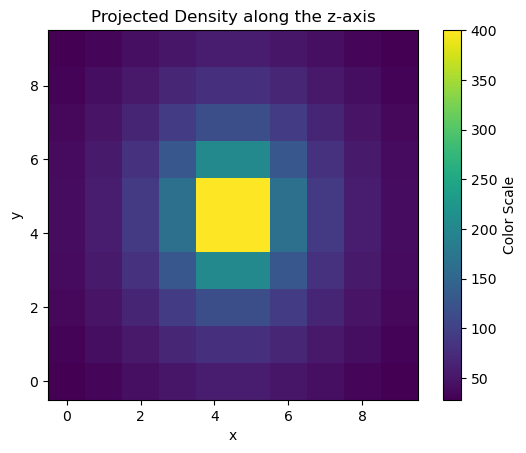

In [149]:
plot_img(densities,'Projected Density along the z-axis')

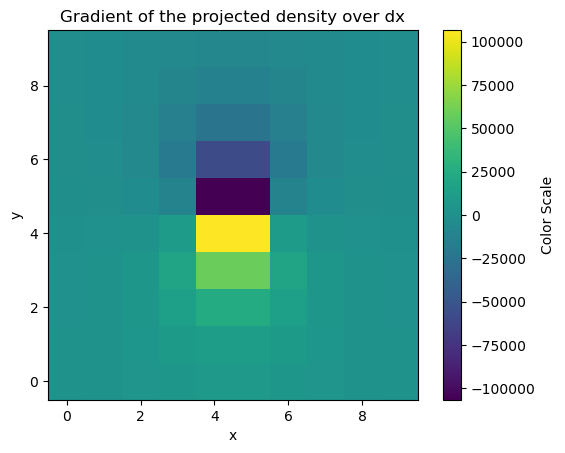

In [150]:
plot_img(gradients[:,:,0],'Gradient of the projected density over dx')

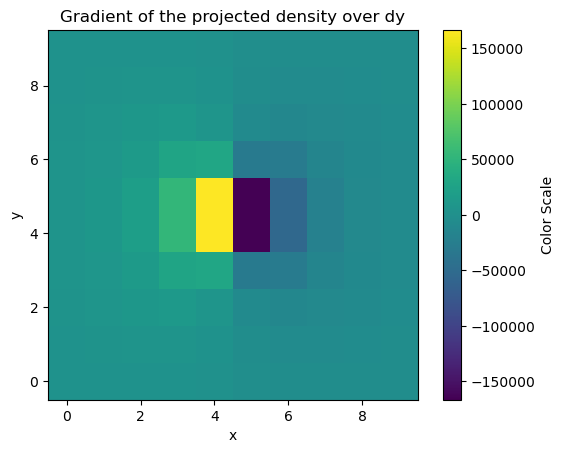

In [151]:
plot_img(gradients[:,:,1],'Gradient of the projected density over dy')

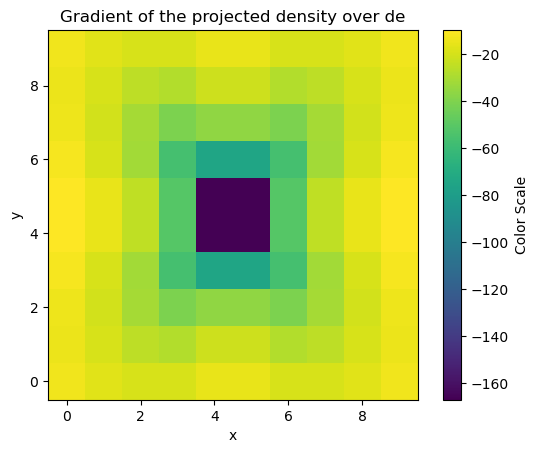

In [152]:
plot_img(gradients[:,:,2],'Gradient of the projected density over de')


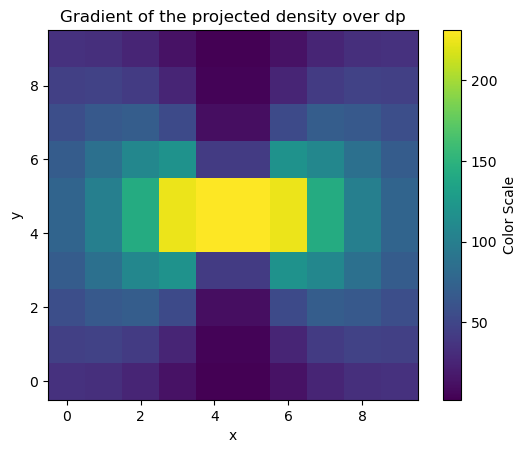

In [153]:
plot_img(gradients[:,:,3],'Gradient of the projected density over dp')


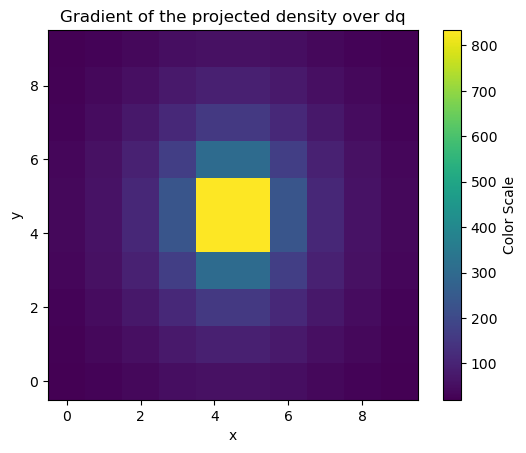

In [154]:
plot_img(gradients[:,:,4],'Gradient of the projected density over dq')
